In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, VotingRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from scipy.stats import randint
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import seaborn as sns

# Загрузка данных CSV
data = pd.read_csv("ValuesResData.csv", encoding="UTF-8")

# Переименование столбцов
data.rename(columns={
    "Floor": "Этаж", "Date": "Дата", "Number of rooms": "Количество комнат",
    "Apartment number": "№ квартиры", "m2": "м2", "Price": "Цена",
    "Remuneration": "Вознаграждение", "Fact of sale": "Факт_продажи", "Address": "Адрес"
}, inplace=True)


# Преобразование столбца 'Дата' в datetime и установка его как индекса DataFrame
data['Дата'] = pd.to_datetime(data['Дата'], errors='coerce')

# Заполнение NaN значений в 'Дата' минимальной датой минус один день
max_date = data['Дата'].max() - pd.Timedelta(days=1)
data['Дата'] = data['Дата'].fillna(max_date)


print(data)

# Преобразование 'Факт продажи' в бинарный признак
data['Факт_продажи'] = data['Факт_продажи'].map({'Yes': 1, 'No': 0})


# Определение числовых признаков для модели
numerical_features = [col for col in data.columns if data[col].dtype in ['int64', 'float64']]

# Преобразование цены и вознаграждения в числовой формат
data["Цена"] = data["Цена"].str.replace(" ", "").astype(float)
data["Вознаграждение"] = data["Вознаграждение"].str.replace(" ", "").astype(float)

# Вычисление цены за м2
data["Цена за m2"] = data["Цена"] / data["м2"]

average_price_per_address = data.groupby("Адрес")["Цена за m2"].mean()

print(average_price_per_address)

# Создание экземпляра LabelEncoder
label_encoder = LabelEncoder()

# Преобразование столбца 'Адрес' в числовые метки
data['Адрес'] = label_encoder.fit_transform(data['Адрес'])

# Проверка типов данных каждого столбца в DataFrame
for column in data.columns:
    if data[column].dtype == 'object' or data[column].dtype.name == 'category':
        print(f"Столбец {column} является категориальным.")
    else:
        print(f"Столбец {column} не является категориальным.")

# Разделение данных на обучающую и тестовую выборки
X = data[numerical_features]
y_price = data['Цена']
y_reward = data['Вознаграждение']
fact_sell = data['Факт_продажи']

# Обучающие и тестовые выборки для цены
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(
    X, y_price, test_size=0.2, random_state=42)

# Обучающие и тестовые выборки для вознаграждения
X_train_reward, X_test_reward, y_train_reward, y_test_reward = train_test_split(
    X, y_reward, test_size=0.2, random_state=42)

# Обучающие и тестовые выборки для факта продажи
X_train_sell, X_test_sell, fact_sell_train, fact_sell_test = train_test_split(
    X, fact_sell, test_size=0.2, random_state=42)

# Создание и обучение моделей
rf_regressor = RandomForestRegressor(random_state=42)
rf_classifier = RandomForestClassifier(random_state=42)
reward_regressor = RandomForestRegressor(random_state=42)

rf_regressor.fit(X_train_price, y_train_price)
rf_classifier.fit(X_train_sell, fact_sell_train)
reward_regressor.fit(X_train_reward, y_train_reward)


# Предсказание цен на тестовой выборке
y_pred_price = rf_regressor.predict(X_test_price)

# Вычисление MSE и R^2 для цены
mse_price = mean_squared_error(y_test_price, y_pred_price)
r2_price = r2_score(y_test_price, y_pred_price)

print(f"MSE для цены: {mse_price}")
print(f"R^2 для цены: {r2_price}")

# Аналогично для вознаграждения
y_pred_reward = reward_regressor.predict(X_test_reward)

mse_reward = mean_squared_error(y_test_reward, y_pred_reward)
r2_reward = r2_score(y_test_reward, y_pred_reward)

print(f"MSE для вознаграждения: {mse_reward}")
print(f"R^2 для вознаграждения: {r2_reward}")

# Для классификации факта продажи используйте точность, так как MSE и R^2 не применимы
fact_sell_pred = rf_classifier.predict(X_test_sell)
accuracy_sell = np.mean(fact_sell_pred == fact_sell_test)

print(f"Точность классификации факта продажи: {accuracy_sell}")

# Для даты!!!

data['Дата'] = (pd.to_datetime(data['Дата']) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D')
# Разделение данных на обучающую и тестовую выборки для даты продажи
X_train_date, X_test_date, y_train_date, y_test_date = train_test_split(
    X, data['Дата'], test_size=0.2, random_state=42)

# Создание и обучение модели для предсказания даты продажи
date_regressor = GradientBoostingRegressor(random_state=42)
date_regressor.fit(X_train_date, y_train_date)

# Предсказание даты продажи на тестовой выборке
y_pred_date = date_regressor.predict(X_test_date)

# Вычисление MSE для даты продажи
mse_date = mean_squared_error(y_test_date, y_pred_date)
print(f"MSE для даты продажи: {mse_date}")


# DF
df = pd.read_csv('DF2025.csv', encoding="UTF-8")

# Переименование столбцов
df.rename(columns={
    "Floor": "Этаж", "Date": "Предсказанная дата продажи", "Number of rooms": "Количество комнат",
    "Apartment number": "№ квартиры", "m2": "м2", "Price": "Предсказанная цена",
    "Remuneration": "Предсказанное вознаграждение", "Fact of sale": "Факт_продажи", "Address": "Адрес"
}, inplace=True)

# Преобразование даты
df['Предсказанная дата продажи'] = (pd.to_datetime(df['Предсказанная дата продажи']) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D')

# Замена пустых дат на 1 марта 2025 года
df['Предсказанная дата продажи'] = pd.to_datetime(df['Предсказанная дата продажи'], errors='coerce')
df['Предсказанная дата продажи'] = df['Предсказанная дата продажи'].fillna(pd.Timestamp('2025-03-01'))


# Установка факта продажи на 'No', если дата отсутствует
df['Факт_продажи'] = df['Предсказанная дата продажи'].apply(lambda x: 'No' if pd.isnull(x) else 'Yes')
df['Факт_продажи'] = df['Факт_продажи'].map({'Yes': 1, 'No': 0})
# Предсказание цен и вероятности продажи для новых данных
X_new = df[numerical_features]
df["Предсказанная цена"] = rf_regressor.predict(X_new)
predicted_probabilities = rf_classifier.predict_proba(X_new)[:, 1]
df["Вероятность продажи"] = predicted_probabilities
df["Предсказанное вознаграждение"] = reward_regressor.predict(X_new)


# Предсказание даты продажи для новых данных
df['Предсказанная дата продажи'] = date_regressor.predict(X_new)
df['Предсказанная дата продажи'] = pd.to_datetime(df['Предсказанная дата продажи'], unit='D', origin='1970-01-01')


# Функция для корректировки дат
def adjust_dates(row):
    # Получаем текущую дату
    current_date = datetime.now()
    # Если предсказанная дата меньше текущей даты, добавляем к ней разницу
    if row['Предсказанная дата продажи'] < current_date:
        # Вычисляем разницу
        delta = current_date - row['Предсказанная дата продажи']
        # Добавляем разницу к текущей дате
        return current_date + delta
    else:
        # Если дата уже в будущем, оставляем её без изменений
        return row['Предсказанная дата продажи']

# Применяем функцию к каждой строке DataFrame
df['Предсказанная дата продажи'] = df.apply(adjust_dates, axis=1)


# Вывод предсказанных цен и вероятностей продажи
print(df[['Предсказанная цена', 'Вероятность продажи', 'Предсказанное вознаграждение', 'Предсказанная дата продажи']])

# Разделение графиков по адресам
unique_addresses = df['Адрес'].unique()

     Этаж       Дата  Количество комнат  № квартиры     м2        Цена  \
0       1 2025-04-30                  3           1  73.76  10 150 000   
1       1 2025-04-30                  2           2  63.96   8 570 000   
2       1 2023-08-01                  1           3  37.07   4 356 800   
3       1 2024-06-01                  1           4  39.40   4 526 800   
4       1 2024-06-01                  1           5  53.55   5 776 800   
..    ...        ...                ...         ...    ...         ...   
716     3 2024-06-01                  2         139  58.21   7 615 132   
717     3 2025-04-30                  2         140  65.28   8 040 000   
718     4 2023-09-01                  3         141  94.55  10 186 800   
719     4 2024-05-01                  2         142  58.21   7 540 000   
720     4 2025-04-30                  2         143  66.20   8 420 000   

    Вознаграждение Факт_продажи         Адрес  
0        5 261 778           No       Dadaeva  
1        4 336 

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Установка стиля Seaborn для красивых графиков
sns.set(style="whitegrid")

df['size'] = df['Количество комнат'].apply(lambda x: x * 50)  # Умножаем количество комнат на 50 для размера

for address in unique_addresses:
    address_data = df[df['Адрес'] == address]
    # Создание фигуры и осей
    fig, ax = plt.subplots(figsize=(15, 10))
    # Отключение сетки
    ax.grid(False)
    # Создание scatter plot
    scatter = sns.scatterplot(
        x='Предсказанная дата продажи',
        y='Предсказанная цена',
        style='Количество комнат',  # Использование количества комнат для формы точек
        hue='Вероятность продажи',  # Цвет точек по вероятности продажи
        size = 'size',
        palette='coolwarm',  # Палитра цветов
        sizes=(50, 200),  # Диапазон размеров точек
        data=address_data,
        ax=ax  # Указание осей для scatterplot
    )

    # Настройка заголовка и меток осей
    ax.set_title(f"Анализ продаж для адреса: {address}", fontsize=16)
    ax.set_xlabel("Предсказанная дата продажи", fontsize=14)
    ax.set_ylabel("Предсказанная цена", fontsize=14)

    # Создание шкалы градиента
    norm = plt.Normalize(vmin=address_data['Вероятность продажи'].min(), vmax=address_data['Вероятность продажи'].max())
    sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
    sm.set_array([])
    # Создание области для colorbar
    cax = fig.add_axes([0.91, 0.25, 0.03, 0.5])  # [left, bottom, width, height]
    # Добавление colorbar к фигуре
    plt.colorbar(sm, cax=cax, label='Вероятность продажи (%)')

    # Сохранение графика в файл с названием адреса
    plt.savefig(f"{address}.png")
    # Закрыть текущее окно с графиком
    plt.close()


In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Установка стиля Seaborn для красивых графиков
sns.set(style="whitegrid")

# Создание новой колонки 'size' в DataFrame, которая будет пропорциональна квадратным метрам
df['size'] = df['м2'].apply(lambda x: x * 1.2)  # Умножаем m2 на 10 для размера

for address in unique_addresses:
    address_data = df[df['Адрес'] == address]
    fig, ax = plt.subplots(figsize=(15, 10))
    # Отключение сетки
    ax.grid(False)
    # Создание scatter plot
    scatter = sns.scatterplot(
        x='Предсказанная дата продажи',
        y='Предсказанная цена',
        style='Количество комнат',  # Использование количества комнат для формы точек
        hue='м2',  # Изменено на колонку м2
        size = 'size',
        palette='coolwarm',  # Палитра цветов
        sizes=(50, 100),  # Диапазон размеров точек, отражающий m2
        data=address_data,
        ax=ax  # Указание осей для scatterplot
    )

    # Настройка заголовка и меток осей
    ax.set_title(f"Анализ продаж для адреса: {address}", fontsize=16)
    ax.set_xlabel("Предсказанная дата продажи", fontsize=14)
    ax.set_ylabel("Предсказанная цена", fontsize=14)

    # Создание шкалы градиента
    norm = mcolors.Normalize(vmin=address_data['м2'].min(), vmax=address_data['м2'].max())
    sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
    sm.set_array([])
    # Добавление шкалы градиента к оси
    plt.colorbar(sm, ax=ax, label='Размер квартиры (м2)')

    # Сохранение графика в файл с названием адреса
    plt.savefig(f"{address}_sales_analysis.png")
    # Закрыть текущее окно с графиком
    plt.close()


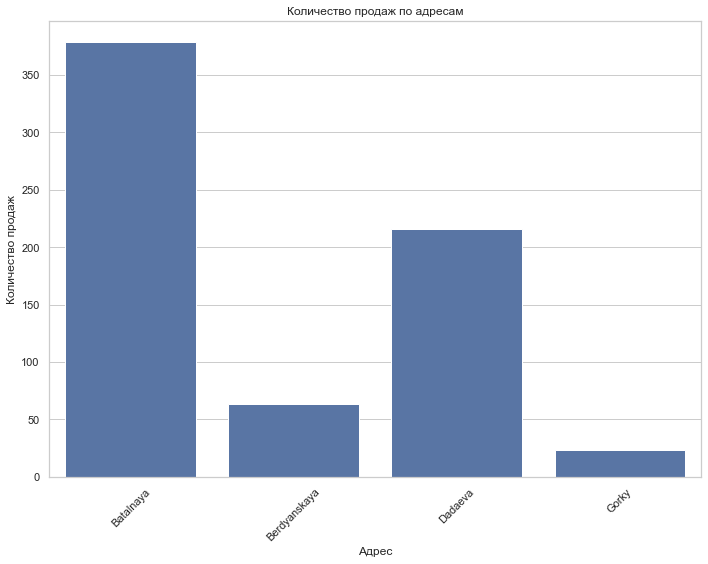

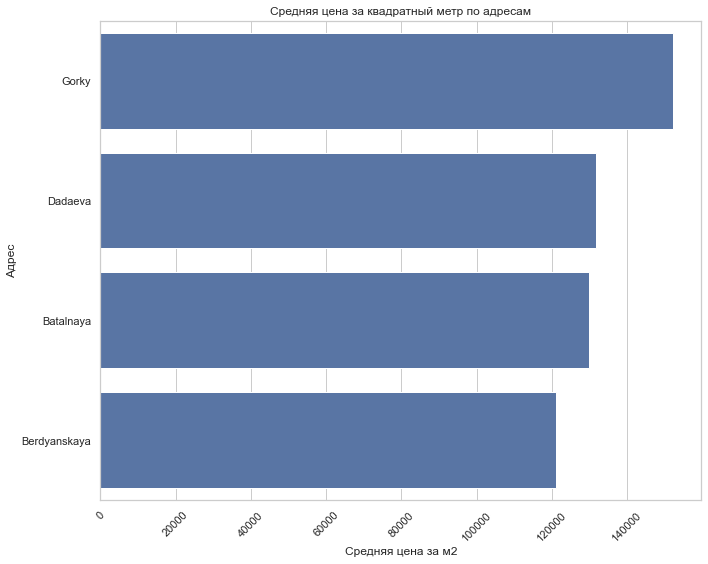

In [47]:

# Подсчет количества продаж по адресам и сохранение 'Адрес' как столбца
sales_count_per_address = df.groupby('Адрес')['Факт_продажи'].sum().reset_index(name='Количество продаж')

# Расчет средней цены за квадратный метр по адресам
average_price_per_m2 = df.groupby('Адрес').agg(
    Сумма_предсказанной_цены=('Предсказанная цена', 'sum')
)
average_price_per_m2['Средняя цена за м2'] = average_price_per_m2['Сумма_предсказанной_цены'] / df.groupby('Адрес')['м2'].sum()

# Сначала отсортируем данные по средней цене для лучшей визуализации
average_price_per_m2_sorted = average_price_per_m2.sort_values('Средняя цена за м2', ascending=False)

# Создание графика количества продаж по адресам
plt.figure(figsize=(10, 8))
sales_count_plot = sns.barplot(x='Адрес', y='Количество продаж', data=sales_count_per_address)
sales_count_plot.set_title('Количество продаж по адресам')
sales_count_plot.set_xlabel('Адрес')
sales_count_plot.set_ylabel('Количество продаж')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Создание графика средней цены за квадратный метр
plt.figure(figsize=(10, 8))
average_price_plot = sns.barplot(x='Средняя цена за м2', y=average_price_per_m2_sorted.index, data=average_price_per_m2_sorted)
average_price_plot.set_title('Средняя цена за квадратный метр по адресам')
average_price_plot.set_xlabel('Средняя цена за м2')
average_price_plot.set_ylabel('Адрес')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
errors_price = y_test_price - y_pred_price
sns.histplot(errors_price, kde=True)
plt.title('Распределение ошибок для цены')
plt.xlabel('Ошибка')
plt.ylabel('Частота')
plt.show()

importances = rf_regressor.feature_importances_
indices = np.argsort(importances)[::-1]
names = [numerical_features[i] for i in indices]

plt.figure()
plt.title("Важность признаков")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), names, rotation=90)
plt.show()

In [ ]:
correlation_matrix = data[numerical_features + ['Цена']].corr()
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, ax=ax)
plt.title("Correlation Matrix")
plt.show()

correlation_matrix = data[numerical_features + ['Вознаграждение']].corr()
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, ax=ax)
plt.title("Correlation Matrix")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Distribution plots for numerical features
numerical_features_to_plot = ['Этаж', 'Количество комнат', 'м2']
for feature in numerical_features_to_plot:
  plt.figure(figsize=(6, 6))
  data[feature].hist()
  plt.title(f"Distribution of {feature}")
  plt.xlabel(feature)
  plt.ylabel("Частота")
  plt.show()